In [233]:
import time
import numpy as np
from scipy.integrate import odeint


def odeintz(func, z0, t, **kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [194]:
#print(t1-t0)

0.49247097969055176


In [78]:
#r = odeint(vectors2, r0, t, args=(I, J))
#r = ode(f, jac).set_integrator('zvode', method='bdf').set_initial_value(r0, 0)

In [76]:
#r.set_initial_value(r0, 0)#.set_f_params(2.0).set_jac_params(2.0)

In [244]:
Gamma_ud=0.4
Gamma_du=0.2
Gamma_el=1.6


gammaplus=Gamma_du/2
gammaminus=Gamma_ud/2
gammaz=Gamma_el/8


Dissipation_factor=1


Gamma=np.array(Dissipation_factor*[gammaplus,gammaminus,gammaz])  #[gamma+,gamma-,gammaz]

In [293]:
rho_init0=np.array([[1/2,1/2],[1/2,1/2]])    #density matrix |+><+|


def trace(A):
    return np.trace(A)

def matmu(A,B):
    return np.matmul(A,B)

#rho_init1=np.array([[1,0],[0,0]])    #By default
#rho_init2=np.array([[1,0],[0,0]])    #By default
N=40

sigma_p= np.array([[0,1],[0,0]])
sigma_m= np.array([[0,0],[1,0]])
sigma_z= np.array([[1,0],[0,-1]])


##Initial values one operator

sp_init0=trace(matmu(rho_init0,sigma_p))
sz_init0=trace(matmu(rho_init0,sigma_z))
sm_init0=trace(matmu(rho_init0,sigma_m))

Genit=[sp_init0,sz_init0,sm_init0]


r0=[]
fact=int(N*(N-1)/2)

r0=[Genit[0]]*N+[Genit[1]]*N+[Genit[0]**2]*fact+[Genit[0]*Genit[2]]*fact+[Genit[0]*Genit[1]]*2*fact+[Genit[1]**2]*fact

In [294]:
def del_list(N):
    
    s=[]
    count=0
    for j in range (0,N):
        s.append((count)%N)
        count=count+1
    
    s_fin=s*(N) 

    count=0
    while count<len(s_fin):
        del(s_fin[count])
        count=count+N
    
    sfin=np.array(s_fin)
    
    return sfin

In [295]:
def up_triang(N):
    ar = np.array(np.zeros((N,N)))
    indices = np.triu_indices_from(ar)
    indexer=[]
    for j in range(len(indices[0])):
        if indices[0][j]!=indices[1][j]:
            indexer.append([indices[0][j],indices[1][j]])
    return np.array(indexer)+N    

In [296]:
def computeIJ(N):
    i = np.zeros((int(N*(5*N-1)/2),int(N*(5*N-1)/2)))
    r0=[]
    extern=np.zeros(int(N*(5*N-1)/2))
    
    for j in range (0,N):
        i[j][j]=-(Gamma[0]+Gamma[1]+4*Gamma[2])

    for j in range (N,2*N):
        i[j][j]=-2*(Gamma[0]+Gamma[1])
        extern[j]=2*(Gamma[0]-Gamma[1])

    for j in range (2*N,int(2*N+N*(N-1)/2)):
        i[j][j]=-2*(Gamma[0]+Gamma[1]+4*Gamma[2])
    for j in range (int(2*N+N*(N-1)/2),int(2*N+N*(N-1))):
        i[j][j]=-2*(Gamma[0]+Gamma[1]+4*Gamma[2])
    
    count=0
    for j in range (int(2*N+N*(N-1)),int(2*N+2*N*(N-1))):
        i[j][j]=-2*(3*(Gamma[0]+Gamma[1])+4*Gamma[2])
        Indexer=del_list(N)
        i[j][Indexer[count]]=2*(Gamma[0]-Gamma[1])
        count=count+1
    count=0        
    for j in range (int(2*N+2*N*(N-1)),int(2*N+5*N*(N-1)/2)):
        i[j][j]=-4*(Gamma[0]+Gamma[1]) 
        i[j][up_triang(N)[count][0]]=-2*(Gamma[1]-Gamma[0])
        i[j][up_triang(N)[count][1]]=-2*(Gamma[1]-Gamma[0])
        count=count+1
        
    return extern, i

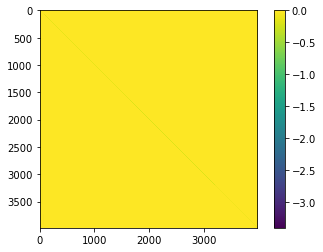

In [297]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(computeIJ(N)[1])
plt.colorbar()
plt.show()

In [298]:
def vectors2(r, t, extern, i):
    s = i @ r  #Vector multiplication
    drdt = s+extern
    return drdt

In [ ]:

extern, i = computeIJ(N)

t = np.linspace(0, 20, 1000)

r = odeintz(vectors2, r0, t, args=(extern, i))

In [ ]:
plt.plot(t,r[:,3])

In [272]:
r0

[0.5, 0.5, 0.0, 0.0, 0.25, 0.25, 0.0, 0.0, 0.25]

In [38]:
np.zeros(int(N*(5*N-1)/2))

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [90]:

s=[]
N=6
count=0
for j in range (0,N):
    s.append((count)%N)
    count=count+1
    
s_fin=s*(N-1)    

def del_list(List,N):
    count=0
    while count<len(List):
        del(List[count])
        count=count+N
    return List
        

In [91]:
del_list(s_fin,N)

[1, 2, 3, 4, 5, 0, 2, 3, 4, 5, 0, 1, 3, 4, 5, 0, 1, 2, 4, 5, 0, 1, 2, 3, 5]

In [100]:
def del_list(N):
    
    s=[]
    count=0
    for j in range (0,N):
        s.append((count)%N)
        count=count+1
    
    s_fin=s*(N-1) 

    count=0
    while count<len(s_fin):
        del(s_fin[count])
        count=count+N
    
    sfin=np.array(s_fin)
    
    return sfin+N

7

In [77]:
s

[0, 1, 2, 3, 0, 1, 2, 0, 1, 2, 3]

In [13]:
N=2

np.zeros((int(N*(5*N-1)/2),int(N*(5*N-1)/2)))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [11]:
np.zeros((2, 4))

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [33]:
N=5
i = np.arange(N)
theta = (2*np.pi)*i/N

I0 = 0.5
I1 = 0.001
I = I0 + I1*np.cos(theta)

J0 = 0.5
J1 = 2.5
delta_theta = np.subtract.outer(theta, theta)
J = J0 + J1*np.cos(delta_theta)

In [34]:
def vectors2(r, t, I, J):
    s = J @ r
    drdt = -r + np.maximum(I + s, 0)
    return drdt

In [46]:
delta_theta

array([[ 0.        , -1.25663706, -2.51327412, -3.76991118, -5.02654825],
       [ 1.25663706,  0.        , -1.25663706, -2.51327412, -3.76991118],
       [ 2.51327412,  1.25663706,  0.        , -1.25663706, -2.51327412],
       [ 3.76991118,  2.51327412,  1.25663706,  0.        , -1.25663706],
       [ 5.02654825,  3.76991118,  2.51327412,  1.25663706,  0.        ]])

In [39]:
computeIJ(6)[1]

array([[ 0.5       ,  0.29166667, -0.125     , -0.33333333, -0.125     ,
         0.29166667],
       [ 0.29166667,  0.5       ,  0.29166667, -0.125     , -0.33333333,
        -0.125     ],
       [-0.125     ,  0.29166667,  0.5       ,  0.29166667, -0.125     ,
        -0.33333333],
       [-0.33333333, -0.125     ,  0.29166667,  0.5       ,  0.29166667,
        -0.125     ],
       [-0.125     , -0.33333333, -0.125     ,  0.29166667,  0.5       ,
         0.29166667],
       [ 0.29166667, -0.125     , -0.33333333, -0.125     ,  0.29166667,
         0.5       ]])

In [42]:
def vectors2(r, t, I, J):
    s = J @ r
    print(s)
    drdt = -r + np.maximum(I + s, 0)
    return drdt


In [47]:
def computeIJ(N):
    i = np.arange(N)
    theta = (2*np.pi)*i/N

    I0 = 0.5
    I1 = 0.001
    I = I0 + I1*np.cos(theta)

    J0 = 0.5
    J1 = 2.5
    delta_theta = np.subtract.outer(i, i)
    J = J0 + J1*np.cos(delta_theta)
    return I, J / N

In [65]:
N=5
i = np.arange(N)
theta = (2*np.pi)*i/N

I0 = 0.5
I1 = 0.001
I = I0 + I1*np.cos(theta)

J0 = 0.5
J1 = 2.5
delta_theta = np.subtract.outer(i, i)

delta_theta

s = (N,N)
A=np.zeros(s)
            

In [66]:
A

array([[0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0.]])

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

## Initial State

In [68]:





r0 = np.random.rand(N)